this problem is define within the book *Reinforcement Learning: An introduction*

you can search the *k-armed bandit problem* for clear definition and explanation.

this project is a fork and added some entended work from 

https://github.com/Mononofu/reinforcement-learning/blob/master/nbandit.py

In [37]:
import abc
#import commands
import functools
import math
import random
import time

import matplotlib.pyplot as plt


class Environment(object):
  __metaclass__ = abc.ABCMeta

  @abc.abstractmethod
  def available_actions(self):
    return []

  @abc.abstractmethod
  def act(self, action):
    return 0.0


class Bandit(Environment): # to define a bandit as an Environment

  def __init__(self, rewards, noise_std):
    '''
        to define an environemnt, that means the reward is settled,
        and the mean time, the settled rewards is defined from the feed from outside(not generated inside a bandit)
    '''
    self.rewards = rewards #the reward vector, array, tensor
    self.n = len(rewards) # the lever the bandit has, n denotes the k when saying k-armed bandit
    self.noise_std = noise_std # in order to confuse the learner / player / agent a little bit, you have to put some noise inside

  def available_actions(self):
    '''
    actually the lever / arm index / number
    '''
    return range(self.n)

  def act(self, action):
    '''
    the agent / player / learner acts on the bandit / environment,
    and the bandit / environment gave back reward for the specific action
    Pay attention to the return statement,
    it gives the current value of the reward based on the action provided and added some noise
    '''
    return self.rewards[action] + random.gauss(0, self.noise_std)

  def __str__(self):
    return 'Bandit(%s, noise_std=%s)' % (self.rewards, self.noise_std)


class GreedyAgent(object):
  '''
  this agent exactly follows its experience and never would take chance to explor
  '''
  def __init__(self, num_actions):
    '''
    it has a vector / array keeping the experience, from the beginning,
    the experice vector is initialized to 0
    and it has a vector to keep to executed time records for each action
    the reason why it is initialized to 1 is this value will be used to do average
    '''
    # action_value_estimates
    self.Q = [0 for _ in range(num_actions)]
    self.action_count = [1 for _ in range(num_actions)]

  def act(self):
    '''
    recall the Q is the vector of its experience
    this is to find the index with which the Q has the greatest value
    '''
    return functools.reduce(lambda a, b: a if self.Q[a] > self.Q[b] else b, range(len(self.Q)))

  def learn(self, action, reward):
    '''
    from the book, the learning method here it is using:
    is to update the experience(Q) with the difference of new reward and the current reward, 
    in the mean time, divides by the times the action was taken.
    this mean the learning rate. assume the new reward contributes only a small part of the total experience
    '''
    self.Q[action] += 1.0 / self.action_count[action] * (reward - self.Q[action])
    self.action_count[action] += 1 # and to update the executed time of the action

  def __str__(self):
    return 'GreedyAgent'


class EpsilonGreedyAgent(GreedyAgent):
  '''
  this agent learns exactly as the GreedyAgent from which it extends / inherites
  but the agent acts different from the Greedy one.
  
  it takes chance to explore some other actions.
  '''

  def __init__(self, num_actions, epsilon):
    super(EpsilonGreedyAgent, self).__init__(num_actions)
    self.epsilon = epsilon
    self.num_actions = num_actions

  def act(self):
    '''
    this is where the difference from.
    
    it takes a posibility of about epsilon to explore, mean it will randomly choose an action to go
    '''
    best_index = super(EpsilonGreedyAgent, self).act()
    if random.random() < self.epsilon:
      '''
      make sure the explored index / action is not the best, otherwise it was not exploring
      but seems it is not able to level up the result of the learning
      '''
      willing_index = random.randint(0, self.num_actions - 1)
      while best_index == willing_index :
        willing_index = random.randint(0, self.num_actions - 1)
      return willing_index
    else:
      return best_index

  def __str__(self):
    return 'EpsilonGreedyAgent(epsilon=%f)' % self.epsilon


class Testbed(object):

  def __init__(self, environment_fn, agent_fns):
    '''
    to prepare a testbed, you will have to provide both environment / bandir and agents / learner / player
    but instead of provide a instantiated instance from a class, provide a method from which can be used to instantiate a instance
    '''
    self.environment_fn = environment_fn # a method used to instantiate a bandit
    self.agent_fns = agent_fns # a series of methods used to instantiate a series of players

  def evaluate(self, num_episodes, episode_length):
    '''
    @param num_episodes: indicates how many time the case should be run
    @param episode_length: indicates inside a episode, how many rounds a player can play / run
    '''
    plt.ion()
    x = range(episode_length) # indicates the x axis in the figure
    self.rewards = [
      [0 for _ in range(episode_length)] for _ in self.agent_fns
    ] 
    # form a 3X1000(num_agents X num_episode_steps) matrix / array 
    # can be used to buffer the averaged rewards from every agent in every step
    # the averaged reward from every episode
    self.fig = plt.figure()
    ax = self.fig.add_subplot(111)
    ax.set_ylim([0, 1.6])

    # Create some fake agents just for the labels.
    environment = self.environment_fn()
    agents = [f(len(environment.available_actions())) for f in self.agent_fns]
    self.lines = [ax.plot(x, rewards, '-', label=str(agent))[0] for rewards, agent in zip(self.rewards, agents)]
    ax.legend(loc=8)

    start = time.time()
    for episode in range(num_episodes):
      environment = self.environment_fn() # initialize a new bandit in each episode / round
      agents = [f(len(environment.available_actions())) for f in self.agent_fns] # and initializes multiple agents which were to play
      for step in range(episode_length): # for every step in an episode
        for i, agent in enumerate(agents): # for every agent and its index
          action = agent.act() # agent act based on its experience and bold
          reward = environment.act(action) # bandit gave back the reward based on the player's action, the reward will contain some noise
          agent.learn(action, reward) # the agent learns from the reward
          self.rewards[i][step] += ((1.0 / (episode + 1)) * (reward - self.rewards[i][step]))
          # based on the newly reward, update the accumulated reward for every episode
          # update a little bit from the changed reward

      if episode % 20 == 0:
        for line, rewards in zip(self.lines, self.rewards):
          line.set_ydata(rewards)
        self.fig.canvas.draw()

      if episode and episode % 100 == 0:
        end_rewards = ', '.join(['%s: %0.2f' % (a, r[-1]) for a, r in zip(agents, self.rewards)])
        eps = episode / (time.time() - start)
        print('Episode %d: %s (%.2f e/s)' % (episode, end_rewards, eps))        
print('done')

done


Episode 100: GreedyAgent: 0.95, EpsilonGreedyAgent(epsilon=0.100000): 1.34 (71.17 e/s)
Episode 200: GreedyAgent: 0.88, EpsilonGreedyAgent(epsilon=0.100000): 1.43 (71.95 e/s)
Episode 300: GreedyAgent: 0.93, EpsilonGreedyAgent(epsilon=0.100000): 1.40 (73.27 e/s)
Episode 400: GreedyAgent: 0.92, EpsilonGreedyAgent(epsilon=0.100000): 1.36 (74.00 e/s)
Episode 500: GreedyAgent: 0.95, EpsilonGreedyAgent(epsilon=0.100000): 1.32 (74.28 e/s)
Episode 600: GreedyAgent: 0.96, EpsilonGreedyAgent(epsilon=0.100000): 1.29 (74.45 e/s)
Episode 700: GreedyAgent: 0.96, EpsilonGreedyAgent(epsilon=0.100000): 1.30 (74.70 e/s)
Episode 800: GreedyAgent: 0.97, EpsilonGreedyAgent(epsilon=0.100000): 1.29 (74.89 e/s)
Episode 900: GreedyAgent: 0.98, EpsilonGreedyAgent(epsilon=0.100000): 1.31 (74.84 e/s)
Episode 1000: GreedyAgent: 0.98, EpsilonGreedyAgent(epsilon=0.100000): 1.30 (74.98 e/s)
Episode 1100: GreedyAgent: 0.98, EpsilonGreedyAgent(epsilon=0.100000): 1.32 (75.16 e/s)
Episode 1200: GreedyAgent: 0.98, EpsilonG

''

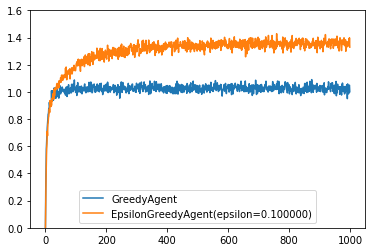

In [39]:
testbed = Testbed(
    environment_fn=lambda: Bandit([random.gauss(0, 1) for _ in range(10)], 1),
    agent_fns=[
        lambda n: GreedyAgent(n),
        lambda n: EpsilonGreedyAgent(n, 0.1)
    ])
testbed.evaluate(num_episodes=2000, episode_length=1000)

print('Done, press enter to exit.')
input()